# Synchronisation in coupled dynamical systems

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

## Identical Synchronisation and transverse stability

The simplest possible synchronisation considers two identical dynamical systems whose dynamics is ruled by the same one-dimensional equation $f(x)$.

In this example, I will be considering a two-dimensional function $f: \mathbb{R}^2 \rightarrow \mathbb{R}^2$.

### Linear Dynamical System

In [3]:
def f(X, t, a=3):
    """
    Simple Linear dynamical system
    """
    x, y = X
    ẋ = -(x + y)
    ẏ = a * x - y
    return ẋ, ẏ

In [4]:
def F(X, t, K=0):
    x, y = X.reshape(2, 2)
    ẋ = f(x, t) - K * (x - y)
    ẏ = f(y, t) - K * (y - x)
    return ẋ[0], ẋ[1], ẏ[0], ẏ[1]

In [5]:
X0 = np.array([
    [1.0, -1.5],
    [0.4, -0.9]
])

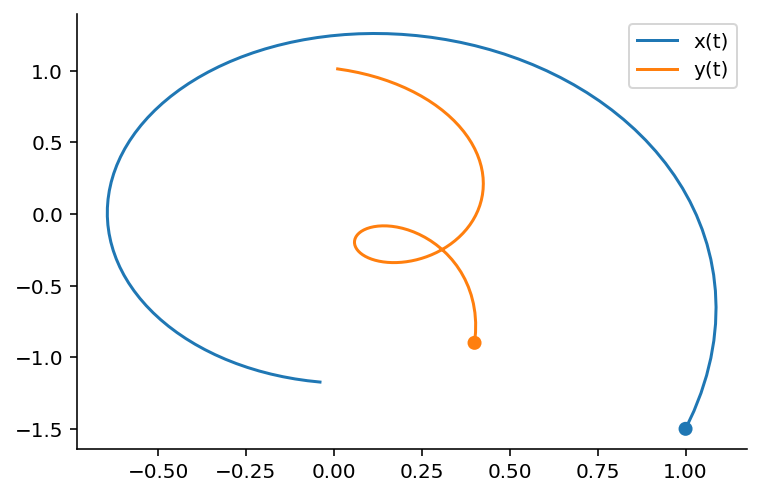

In [6]:
T = 100
time = np.linspace(0, 3, T)
X = odeint(F, X0.ravel(), time, args=(-0.6,)).reshape(T, 2, 2)

plt.plot(*X[:, 0, :].T, label="x(t)")
plt.plot(*X[:, 1, :].T, label="y(t)")
plt.scatter(*X0.T, c=["tab:blue", "tab:orange"])
plt.legend()

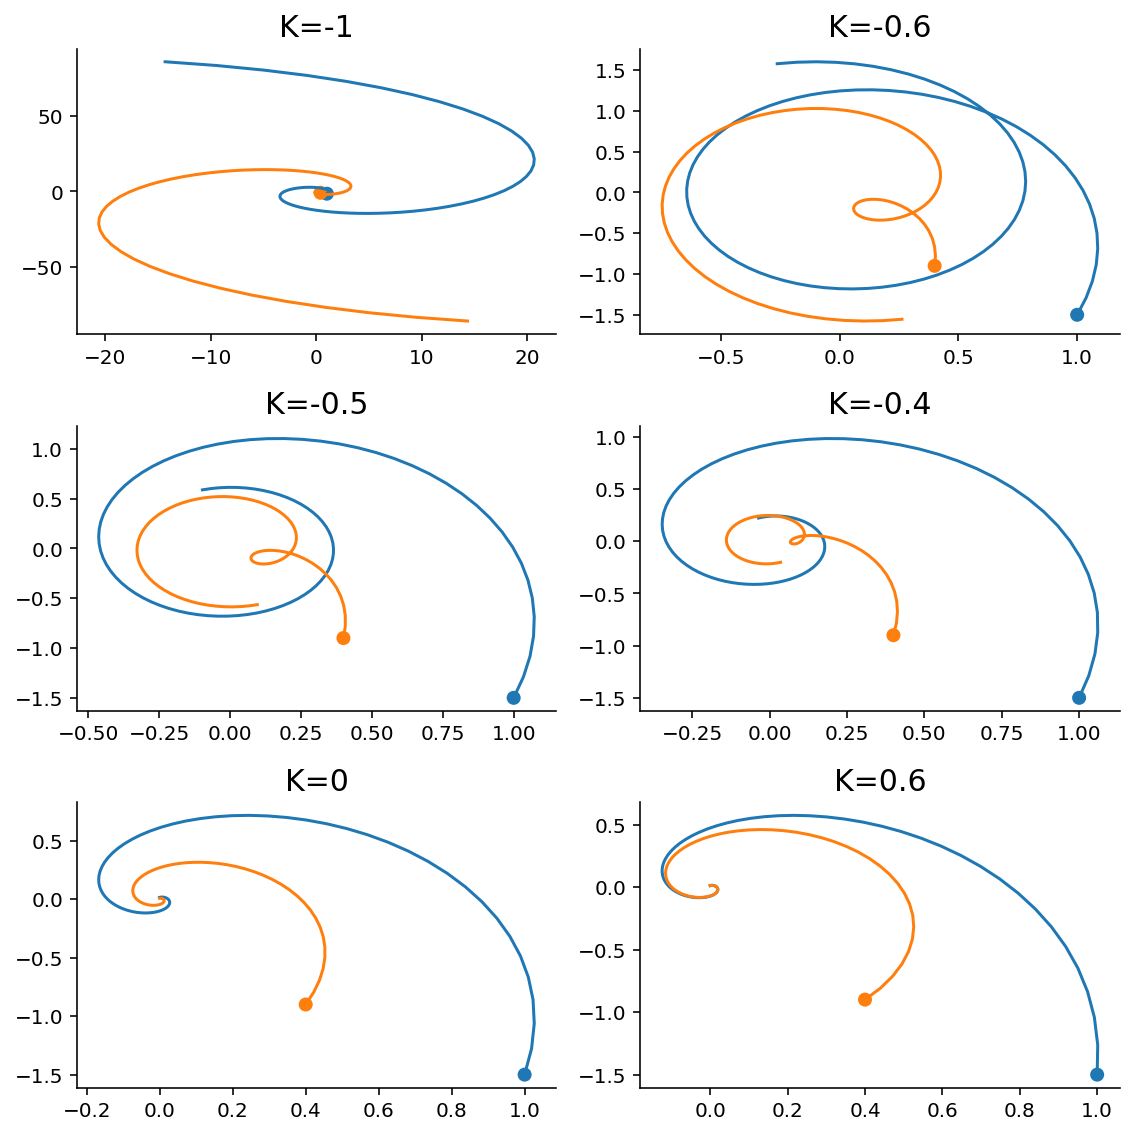

In [7]:
K_values = [-1, -0.6, -0.5, -0.4, 0, 0.6]
fig, ax = plt.subplots(3, 2, figsize=(8, 8))
ax = ax.ravel()

steps = 100
T = 5
time = np.linspace(0, 5, steps)

for K, axi in zip(K_values, ax):
    X = odeint(F, X0.ravel(), time, args=(K,)).reshape(steps, 2, 2)
    axi.plot(*X[:, 0, :].T)
    axi.plot(*X[:, 1, :].T)
    axi.scatter(*X0.T, c=["tab:blue", "tab:orange"])
    axi.set_title(f"{K=}", fontsize=15)
plt.tight_layout()

### Duffing oscillator

In [8]:
def sync_two_identical(X, t, f, K=0):
    """
    Synchronises two identical dynamical systems
    via a parameter K
    """
    x, y = X.reshape(2, 2)
    ẋ = f(x, t) - K * (x - y)
    ẏ = f(y, t) - K * (y - x)
    return ẋ[0], ẋ[1], ẏ[0], ẏ[1]

In [9]:
def g(X, t=0, γ=0.6):
    """
    Duffing oscilator dynamical system
    """
    x, y = X
    ẋ = y
    ẏ = - γ * y + x - x ** 3
    return ẋ, ẏ

In [10]:
x0 = np.array([-1.0, -2.0])
y0 = np.array([0.5, 1.5])

T, steps = 6, 200
time = np.linspace(0, T, steps)
xt = odeint(g, x0, time)
yt = odeint(g, y0, time)

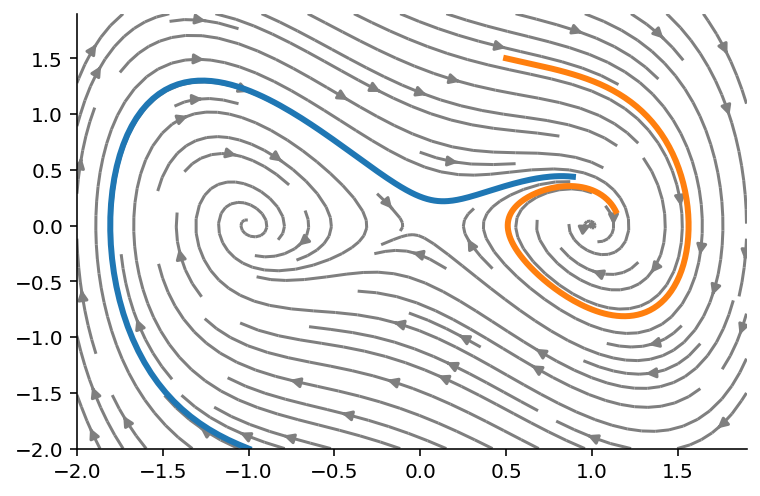

In [11]:
Xmap = np.mgrid[-2:2:0.1, -2:2:0.1][::-1]
plt.streamplot(*Xmap, *g(Xmap), color="tab:gray")
plt.plot(*xt.T, linewidth=3)
plt.plot(*yt.T, linewidth=3)

In [12]:
X0 = np.array([
    [-1.0, -2.0],
    [-1.1, -1.9],
])

sync_two_identical(X0, time, g)

(-2.0, 1.2, -1.9, 1.3710000000000002)

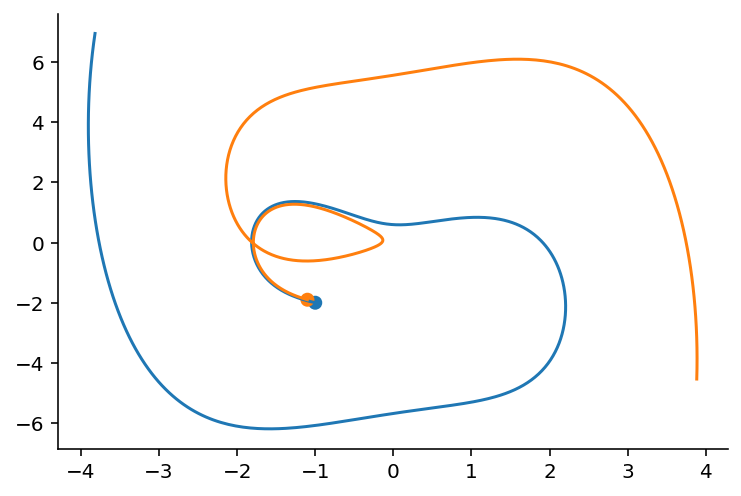

In [13]:
T, steps = 6, 1000
time = np.linspace(0, T, steps)

Xt = odeint(sync_two_identical, X0.ravel(), time, args=(g, -0.5)).reshape(steps, 2, 2)

xt = Xt[:, 0, :]
yt = Xt[:, 1, :]

plt.plot(*xt.T)
plt.plot(*yt.T)
plt.scatter(*X0.T, c=["tab:blue", "tab:orange"])

## General Coupling

Suppose we have $L$ dynamical systems with local dynamics given by $f$, then the equations of motion for the $L$-coupled dynamical system is given by

$$
    \dot x_\ell(t) = f(x_\ell(t)) + \sigma \big[(L-1) g(x_\ell(t)) - \sum_{j\neq\ell} g(x_\ell(t)) \big]
$$

In [14]:
def sync_two_identical(X, t, f, K=0):
    """
    Synchronises two identical dynamical systems
    via a parameter K
    """
    x, y = X.reshape(2, 2)
    ẋ = f(x, t) - K * (x - y)
    ẏ = f(y, t) - K * (y - x)
    return ẋ[0], ẋ[1], ẏ[0], ẏ[1]

In [15]:
def coupling(X, t, f, σ=0):
    """
    Synchronise L identical 2-dimensional dynamical
    systems via a linear interaction
    
    Parameters
    ----------
    X: np.array(L, 2)
        Current system positions
    t: float
        Current time
    f: function
        local dynamics
    σ: float
        Coupling factor
    """
    X = X.reshape(-1, 2)
    L, _ = X.shape
    x_values = []
    for l in range(L):
        mapping = np.ones((L, 2))
        mapping[l, :] = 0
        xl = f(X[l], t) - σ * ((L - 1) * X[l] - (X * mapping).sum(axis=0))
        x_values.extend(xl)
    return x_values

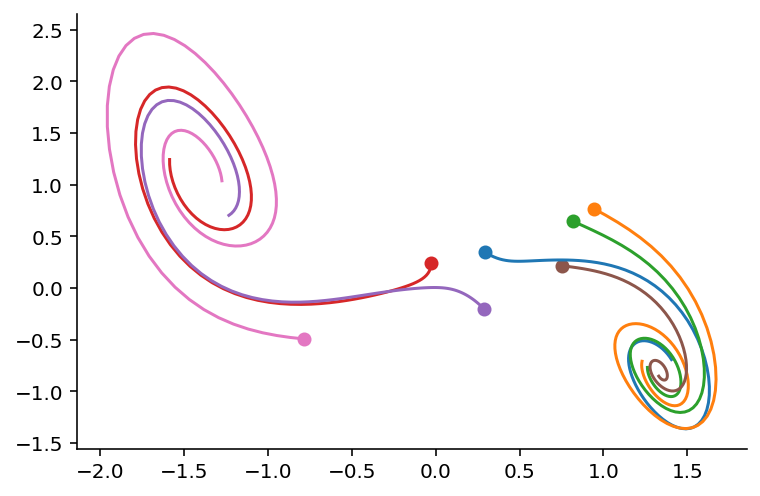

In [16]:
T, steps = 6, 100
time = np.linspace(0, T, steps)
np.random.seed(31415)

top, bottom = -1, 1
X0 = np.random.rand(7, 2) * (bottom - top) - bottom

nsims, _ = X0.shape
Xt = odeint(coupling, X0.ravel(), time, args=(lambda X, t: g(X, t, γ=2), -0.1)).reshape(steps, nsims, 2)

for i in range(nsims):
    xt = Xt[:, i, :]
    plt.plot(*xt.T)
    plt.scatter(*X0[i])